# Least Squares Classifier on MNIST

## Imports

In [1]:
from mlxtend.data import loadlocal_mnist
import platform
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import time as time

__Note:__ mlxtend can be installed by executing `pip install mlxtend`  

## Setup
These will be the global variables that I used throughout this project. `X` and `X_test` is the training and test set, respectively. `y` and `y_test` are the corresponding labels of the training and test set, respectively.  

In [2]:
# Loading MNIST into NumPy Arrays
if not platform.system() == 'Windows':
    X, y = loadlocal_mnist(
            images_path='train-images-idx3-ubyte', 
            labels_path='train-labels-idx1-ubyte')
    X_test, y_test = loadlocal_mnist(
            images_path='t10k-images-idx3-ubyte', 
            labels_path='t10k-labels-idx1-ubyte')

else:
    X, y = loadlocal_mnist(
            images_path='train-images-idx3-ubyte', 
            labels_path='train-labels-idx1-ubyte')
    X_test, y_test = loadlocal_mnist(
            images_path='t10k-images-idx3-ubyte', 
            labels_path='t10k-labels-idx1-ubyte')

In [3]:
print('Dimensions: %s x %s' % (X.shape[0], X.shape[1]))
print('\n1st row', X[0])

Dimensions: 60000 x 784

1st row [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 1

In [4]:
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(y))
print('Class distribution: %s' % np.bincount(y))

Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


## One vs. All Classifier
The least squares multiclassification method for the MNIST digit classification can be represented as computing a least squares Boolean classifier for each of the 10 digits, encoded as <i>k</i> = 1,...,10: 
<div align = center> <i>f(x)<sub>prediction for k</sub></i> = <b>sign</b>(<i>x<sup>T</sup>β<sub>k</sub> + v<sub>k</sub></i>)</div>
The ten Boolean classifiers are then combined into a multi-class classifier:
<div align = center> <i>f(x)<sub>prediction</sub></i> = <b>argmax</b><sub><i>k = 1,...,10</i></sub>(<i>x<sup>T</sup>β<sub>k</sub> + v<sub>k</sub></i>)</div>

To find <i>β<sub>k</sub></i> for each <i>k</i>, we can make use of the Ordinary Least Squared Estimator, which is denoted as:
<div align = center> <i>β<sub>k</sub></i> = <i>(X<sup>T</sup>X)<sup>-1</sup>X<sup>T</sup>y<sub>k</sub></i> ,</div> 
where <i>X</i> is our <i>design matrix</i> (in this case, the training set) and <i>y<sub>k</sub></i> is the <i>target vector</i> for <i>k</i>. 

So to train the classifiers, I first needed to create the _target vector_ for each _k_. This was done by creating a vector where the elements are _+1_ if the associated value of the feature vector is equal to our current digit _k_, and _-1_ if not. I wrote the following methods __`target`__, for deriving the target vector for each _k_ and __`compute_targets`__, for storing them into a list.

In [5]:
def target(digit):
    """ 
    Returns the target vector for the digit encoded by k, 
    where the elements are +1 if the kth training label == k 
    and -1 otherwise
    """
    target = np.ones(len(y))
    for i in range(len(y)):
        if digit != y[i]:
            target[i] = -1
    return target 

In [6]:
def compute_targets():
    """ 
    Returns a list containing the target vector for 
    each k
    """
    targets = []
    for i in range(10):
        targets.append(target(i))
    return targets

I accounted for the bias term, <i>v<sub>k</sub></i>, by appending a 1 to the front of every feature vector of our design matrix, `X`. This means that when we compute <i>β<sub>k</sub></i>, <i>v<sub>k</sub></i> would be the first element of this vector. This functionality is defined in __`append_ones`__.

In [7]:
def append_ones(X):
    """
    Append a 1 to every feature vector in the design matrix
    """
    ones = np.ones((len(X), 1))
    X = np.hstack((ones, X))    
    return X

Because matrix multiplications are computationally expensive in the sizes that we are dealing with, I decided to save each of the <i>β<sub>k</sub></i> vectors to a global scope after training each classifier once to avoid a large runtime. I defined the following method __`A`__, to calculate the matrix <i>(X<sup>T</sup>X)<sup>-1</sup>X<sup>T</sup></i>, which I denoted as <i>A</i>, and __`compute_betas`__, which calculated the <i>β<sub>k</sub></i> vectors by multiplying the matrix <i>A</i> with the target vector, <i>y<sub>k</sub></i>.

In [8]:
def A(X):
    """
    Calculates the matrix A, where 
        A = (X^T*X)^-1(X^T)
    """
    inner_prod = X.T.dot(X)
    outer_prod = np.linalg.pinv(inner_prod).dot(X.T)
    return outer_prod

In [9]:
def compute_betas(A_matrix, targets):
    """
    Calculates B_k for each k, and stores them into a list 
    that is returned
    
    B_k is determined by multiplying the matrix A with y_k
    """
    betas = []
    for i in range(10):
        target_vector = targets[i]
        betas.append(A_matrix.dot(target_vector))
    return betas

### Running the One vs All Classifier
Now with all the helper functions defined, I wrote the following method, __`one_vs_all_classify`__, to perform One vs All Classification using the training set of 60,000 images. In this method, after training the classifiers, I tested the model using the test set of 10,000 images and returned an array of the predicted labels for every image in the test set.

In [10]:
def one_vs_all_classify():
    """
    The classification model uses the the training set, X, to train a 
    least squares Boolean classifier on every k
    
    Once trained, every image of the test set, X_test, is passed to each of
    the k Boolean classifiers
    """
    
    # Append 1's to X and X_test
    design_matrix_train = append_ones(X) 
    design_matrix_test = append_ones(X_test)
    
    # Determine the matrix A, using ((X^T)X)^-1(X^T)
    A_matrix = A(design_matrix_train)
    # Determine the target vectors, y_k, and store into list
    targets = compute_targets()
    # Determine vectors B_k and store into list
    betas = compute_betas(A_matrix, targets)                     
    
    # Initialize list for predicted labels
    predicted_y = np.zeros(len(y_test))
    
    # Iterate through images in the test set
    for i in range(len(X_test)):
        outputs = np.zeros(10)
        # Apply each classifier to the image
        for j in range(10):
            beta_vector = betas[j]
            outputs[j] = design_matrix_test[i].dot(beta_vector)
        # Index of max output after multiplying feature vector with B_k is the predicted label
        predicted_y[i] = np.argmax(outputs)                      
    return predicted_y

In [11]:
# RUN THIS CELL TO PERFORM ONE VS ALL CLASSIFICATION
start = time.time()
one_vs_all_predicted = one_vs_all_classify()
end = time.time()
print('Total runtime for One vs All Classification was {} seconds'.format(round(end - start, 3)))

Total runtime for One vs All Classification was 7.452 seconds


### Confusion Matrix
The following method, __`confusion_matrix`__ takes in our predicted and actual labels, and returns a confusion matrix.

In [12]:
def confusion_matrix(actual, predicted):
    """
    Returns a confusion matrix by taking the predicted
    and actual labels of the test set
    """
    int_predicted = predicted.astype(int)
    c_matrix = np.zeros([10, 10])
    for i, digit in enumerate(actual):
        c_matrix[digit][int_predicted[i]] += 1
    return c_matrix.astype(int)

The predicted labels are stored in `one_vs_all_predicted` which I passed in to __`confusion_matrix`__ along with the test labels, `y_test`.

In [18]:
# RUN THIS CELL TO PRINT OUT A CONFUSION MATRIX FOR ONE VS ALL
one_vs_all_confusion = confusion_matrix(y_test, one_vs_all_predicted)
print(one_vs_all_confusion)

[[ 944    0    1    2    2    7   14    2    7    1]
 [   0 1107    2    2    3    1    5    1   14    0]
 [  18   54  813   26   15    0   42   22   37    5]
 [   4   17   23  880    5   17    9   21   22   12]
 [   0   22    6    1  881    5   10    2   11   44]
 [  23   18    3   72   24  659   23   14   39   17]
 [  18   10    9    0   22   17  875    0    7    0]
 [   5   40   16    6   26    0    1  884    0   50]
 [  14   46   11   30   27   40   15   12  759   20]
 [  15   11    2   17   80    1    1   77    4  801]]


I visualized this confusion matrix in __`viz_confusion`__ through a heatmap with the help of Python's data visualization libary, _Seaborn_. In creating the function to visualize the confusion matrix, I referenced the code from this source : https://www.kaggle.com/agungor2/various-confusion-matrix-plots 

In [19]:
def viz_confusion(c_matrix, classifier_name):
    """
    Visualizes the confusion matrix as a Seaborn heatmap
    
    Code was partially referenced from:
    https://www.kaggle.com/agungor2/various-confusion-matrix-plots
    """
    labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    visual = pd.DataFrame(c_matrix, columns = labels, index = labels)
    plt.figure(figsize = (9, 5))
    sb.heatmap(visual, cmap="Blues", annot = True, fmt='d')
    plt.title('Heatmap of Confusion Matrix for {}'.format(classifier_name))
    plt.xlabel('Prediction', fontsize = 15)
    plt.ylabel('Digit')

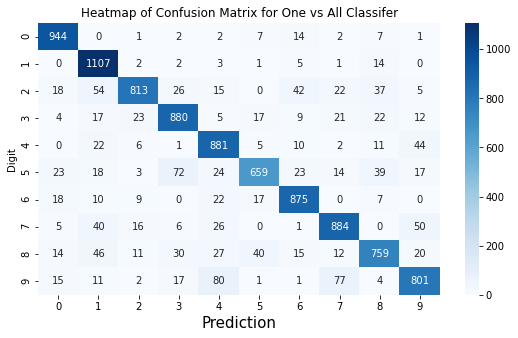

In [20]:
# RUN THIS CELL TO PRODUCE A HEATMAP OF THE CONFUSION MATRIX
viz_confusion(one_vs_all_confusion, 'One vs All Classifer')

### Error Rate
The _error rate_ is the total number of errors in the predicted labels divided by the total number of images classified. I defined __`err_rate`__ to compute the error rate of the classification model.

In [21]:
def err_rate(c_matrix):
    """
    Computes the error rate from a given confusion matrix
    """
    correct = 0 
    for i in range(len(c_matrix)):
        correct += c_matrix[i][i]
    error_rate = (10000 - correct)/10000
    return error_rate*100

In [22]:
# RUN THIS CELL TO PRINT AN ERROR RATE FOR THE CLASSIFIER
error_rate = err_rate(one_vs_all_confusion)
print('The error rate for One vs All Classification is {}%'.format(round(error_rate, 2)))

The error rate for One vs All Classification is 13.97%


### Evaluation of the One vs All Classifier
The _error rate_ on the test set of 10000 images approximately turned out to be 13.97%. Considering that the Boolean classifiers were trained exclusively on the training set, `X`, I would say an 86% classification rate is pretty successful. Though not perfect, the One vs All classifier managed to, for the most part, generalize the best fit line on a new test set of arbitrary handwritten images.  

The most common error corresponds to when the digit is _9_, but was predicted to be _4_ as a total of 80 images were misclassified this way. This makes sense as the two numbers can be very similar when handwritten. Commmon misclassifications also included when _9_ was also predicted to be _7_, and _5_ was predicted to be _3_. I also assumed that the digit _8_ would get frequently misclassified as the digit _3_, but surprisingly _8_ was most commonly misidentified as _1_ or _5_. The most easily recognized digits by far seem to be _0_ and _1_, likely because they have the most distinct curvatures in shape. 

As for the computational performance, it took me a while to figure out how to effectively speed up the matrix multiplications. Initially, 10 iterations took me around 3 minutes. Extrapolating this to 10000 iterations (one iteration for every image in the test set), it would've taken me around 50 hours to train and test. I managed to work around this problem by training the Boolean classifiers first and saving the <i>β<sub>k</sub></i> vectors for each digit to a global scope in the method. That way for every image, I didn't have to calculate <i>β<sub>k</sub></i> again ten times for each digit. In the end, my runtime was drastically reduced to about 5 - 8 seconds, which I was very happy about.

## One vs One Classifier
In this part, pairwise Boolean classifiers are constructed for every pair of classes _i_, _j_, where (_i_ < _j_). Thus, for every classifier, we are only considering the subset of `X` where the training labels for the feature vectors are of class _i_ and _j_.  There are a total of _K(K - 1)/2_ classifiers. For this data set, since _K_ = 10, there will be 45 one vs one classifiers that we would have to train.

I would still have to create the target vectors, <i>y<sub>i,j</sub></i>, where the elements are +1 if the training label corresponds to class _i_ and -1 if the label corresponds to class _j_. But this time we will have to create 45 target vectors instead of 10, because there are 45 classifiers. And since I am also computing the <i>β<sub>i,j</sub></i> for 45 classifiers it makes sense to compute all of them at once and store them into a global scope again, since the One vs One Classifier will definitely be more computationally expensive. 

But first, I defined the following method, __`tuple_list`__, which computes all the possible pairs of classes given _K_.

In [23]:
def tuple_list(K):
    """
    Returns a list of tuples that holds every pair of classes
    in K classes
    """
    tuples = []
    i_start = 0
    j_start = 1
    for i in range(i_start, K - 1):
        for j in range(j_start, K):
            tuples.append((i, j))
        i_start+=1
        j_start+=1
    return tuples

In [24]:
# RUN THIS CELL TO DEMONSTRATE METHOD FUNCTIONALITY
print(tuple_list(10))
print('{} pairs in 10 classes'.format(len(tuple_list(10))))

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]
45 pairs in 10 classes


I defined the following functions, __`target_pair`__ and __`compute_targets_pair`__ for creating target vectors, <i>y<sub>i,j</sub></i>, for every possible pair of classes _i_ and _j_, and storing them into a list.

In [25]:
# Creates a target vector for a pair of classes i and j
def target_pair(class_i, class_j):
    """
    Creates a target vector, y_{i,j}, for a pair of classes i and j
    """
    y_labels = y[(y == class_i) | (y == class_j)]
    target = np.ones(len(y_labels))
    for i, digit in enumerate(y_labels):
        if digit != class_i:
            target[i] = -1
    return target

In [26]:
def compute_targets_pair(tuples):
    """
    Takes a list of all possible pairs of classes i and j, and computes
    a target vector, y_{i,j}, for each pair
    
    Returns a list of K(K-1)/2 target vectors
    """
    targets = []
    for _tuple in tuples:
        target_vector = target_pair(_tuple[0], _tuple[1])
        targets.append(target_vector)
    return targets

The following methods, __`A_pair`__, calculates the matrix <i>(X<sub>i,j</sub><sup>T</sup>X<sub>i,j</sub>)<sup>-1</sup>X<sub>i,j</sub><sup>T</sup></i>, where this time however, X<i><sub>i,j</sub></i> is the subset of the feature vectors of `X` that have the class labels _i_ and _j_. I denoted the resulting matrix of this method as <i>A<sub>i, j</sub></i>.  The method __`compute_betas_pair`__ calculates the beta vectors, <i>β<sub>i,j</sub></i>, by multiplying the matrix <i>A<sub>i,j</sub></i> with <i>y<sub>i,j</sub></i>.

In [27]:
def A_pair(X_subset):
    """
    Calculates the matrix A_{i,j}, where 
        A_{i,j} = (X_{i,j}^T*X_{i,j})^-1(X_{i,j}^T)
    """
    inner_prod = X_subset.T.dot(X_subset)
    outer_prod = np.linalg.pinv(inner_prod).dot(X_subset.T)
    return outer_prod

In [28]:
def compute_betas_pair(X, targets, tuples):
    """
    Calculates B_{i,j} for each pair i and j, and stores them into a list 
    that is returned
    
    B_{i,j} is determined by multiplying the matrix A_{i,j} with y_{i,j}
    """
    betas = []
    for i, _tuple in enumerate(tuples):
        A_matrix = A(X[(y == _tuple[0]) | (y == _tuple[1])])
        beta = A_matrix.dot(targets[i])
        betas.append(beta)
    return betas

### Running the One vs One Classifier
Now with all the helper functions defined, I wrote the following method, __`one_vs_one_classify`__, to perform One vs One Classification using the training set, `X`,  of 60,000 images. In this method, after training the classifiers, I tested the model using the test set, `X_test`, of 10,000 images and returned an array of the predicted labels for every image in the test set.

In [29]:
def one_vs_one_classify():
    """
    The classification model uses the the training set, X, to train a 
    least squares Boolean classifier on every pair of classes i, j in 
    K classes
    
    Once trained, every image of the test set, X_test, is passed to each of
    the K(K-1)/2 Boolean classifiers
    """
    
    # Create a list of pairs for K classes
    K = 10
    tuples = tuple_list(K)
    
    # Append 1's to X and X_test
    design_matrix_train = append_ones(X)
    design_matrix_test = append_ones(X_test)
    
    # Determine target vectors, y_{i,j}, and store into list
    targets = compute_targets_pair(tuples)
    # Determine vectors B_{i,j} and store into list
    betas = compute_betas_pair(design_matrix_train, targets, tuples)   
    
    # Initialize list for predicted labels
    predicted_y = np.zeros(len(y_test))
    
    # Iterate through images in test set
    for i in range(len(X_test)):
        # Initalize list for the votes
        votes = [0] * 10
        # Apply each classifier to image
        for j, _tuple in enumerate(tuples):
            sign = np.sign(design_matrix_test[i].dot(betas[j]))
            # Depending on outcome of classifier, increment vote of appropriate class
            if sign > 0:
                votes[_tuple[0]]+=1
            else:
                votes[_tuple[1]]+=1
        #predicted_y[i] = votes.index(max(votes))
        predicted_y[i] = np.argmax(votes)
    return predicted_y

In [31]:
# RUN THIS CELL TO PERFORM ONE VS ONE CLASSIFICATION
start = time.time()
one_vs_one_predicted = one_vs_one_classify()
end = time.time()
print('Total runtime for One vs One Classification was {} seconds'.format(round(end - start, 2)))

Total runtime for One vs One Classification was 59.31 seconds


### Confusion Matrix
The predicted labels are stored in `one_vs_one_predicted` which we pass in to our confusion matrix function along with the test labels, `y_test`.

In [32]:
# RUN THIS CELL TO PRINT OUT A CONFUSION MATRIX FOR ONE VS ONE
one_vs_one_confusion = confusion_matrix(y_test, one_vs_one_predicted)
print(one_vs_one_confusion)

[[ 961    0    1    1    0    6    8    3    0    0]
 [   0 1120    3    3    1    1    4    1    2    0]
 [   9   18  936   12   10    5   10   10   22    0]
 [   9    1   18  926    2   20    1    7   21    5]
 [   2    4    6    1  931    1    7    4    3   23]
 [   7    5    3   30    8  800   17    2   15    5]
 [   6    5   12    0    5   19  908    1    2    0]
 [   1   16   17    3   11    1    0  955    1   23]
 [   7   17    8   23   10   36   10   10  840   13]
 [   6    5    1   11   30   12    0   21    3  920]]


A visual representation of the confusion matrix as a heatmap is as follows.

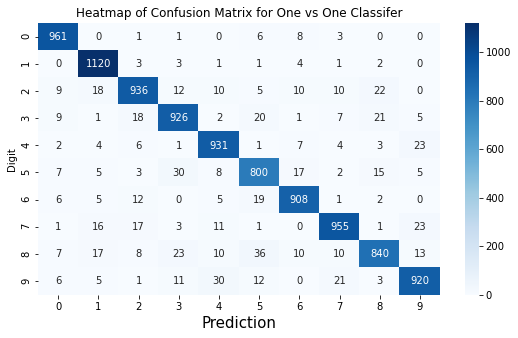

In [33]:
# RUN THIS CELL TO PRODUCE A HEATMAP OF THE CONFUSION MATRIX
viz_confusion(one_vs_one_confusion, 'One vs One Classifer')

### Error Rate
The error rate can be computed below.

In [34]:
# RUN THIS CELL TO COMPUTE AN ERROR RATE FOR THE CLASSIFIER
error_rate = err_rate(one_vs_one_confusion)
print('The error rate for One vs One Classification is {}%'.format(round(error_rate, 2)))

The error rate for One vs One Classification is 7.03%


### Evaluation of One vs One Classifier
The error rate on the test set was approximately 7.03%. Considering that the Boolean classifiers were trained using only on the training set, I would say One vs One classification was extremely succesful in generalizing on the test data set, more so than the One vs All classifier which produced an almost doubled the error rate. I think the reason behind why this classifier was a little more successful is because of the "voting" intuition behind the classification. Each classifier "votes" on if the image belongs to a class _i_ or _j_. And since there are K(K-1)/2 classifiers in total that work to differentiate between every pair _i_, _j_ in K, an image in the test set of class _i_ can be more confidently classified as class _i_. Thus, this model will be less sensitive to misclassification.  

The most common error corresponds to when the digit _8_, was predicted to be _5_. Likewise to the One vs All Classifier, this classification method also had trouble in differentiating between _9_ and _4_, and _5_ and _3_.

As for computational performance, I followed the same technique as above where I saved my beta vectors to a global scope once calculated before testing the images in my test set. This time around, there were 45 classifiers in total, so the runtime was longer, fluctuating between 47-60 seconds.

## Comparing Both Classifiers
The error rate for the One vs All Classification was determined to be 13.97% while the error rate for the One vs One Classification was 7.03%. The intuition behind this difference is largely due to the way each classifier is implemented. As dicussed above, the One vs All Classifer is only determining whether an image in the test set is either "is" or "is not" a digit. That means the target vector for each digit contains +1 if the associated feature vector in the training set is of class k, or -1 if it isn't. This leads to an unbalanced distribution as the set of -1's are far larger than the set of +1's. Thus, it is harder to establish an accurate decision boundary separating the images of a specific digit and the rest of the dataset, especially if the digits are closer together in the 784-vector space (as 9 and 4, 9 and 7 seem to be).

One vs One Classification curbs this problem by creating a decision boundary separating every unique pair of classes _i_ and _j_ in K classes. This would solve the issue of unbalanced distribution since the quantities of each digit seem to be roughly equal. 

Computationally speaking, implementing 45 classifiers compared to 10 is definitely more expensive, proven by the stark difference in the runtime.